# Задачи поиска
Представлены основные алгоритмы поиска.


## Поиск ДНК
При компьютерной обработке гены обычно представляются последовательностью символов A, C, G, T, обозначающих **нуклеотиды**: *аденин, цитозин, гуанин, тимин*. Комбинация трех нуклеотидов образует **кодон**. Кодон кодирует конкретную аминокислоту. Комбинация аминокислот образует белок.  

Классическая задача в биоинформатике - найти определенный кодон в гене.

In [1]:
# хранение ДНК
# IntEnum дает возможность использовать операторы сравнения
from enum import IntEnum

Nucleotide = IntEnum('Nucleotide', ('A', 'C', 'G', 'T'))

# Кодон - кортеж из трех элементов
# Codon = tuple(Nucleotide, Nucleotide, Nucleotide)
# Ген - список кодонов
# Gene = list(Codon)

def string_to_gene(string):
    gene = []
    n = len(string)
    
    for i in range(0, n, 3):
        if (i+2) >= n:
            # остался один или два нуклеотида (кодон не образуется)
            return gene
        
        codon = (Nucleotide[string[i]], Nucleotide[string[i+1]], Nucleotide[string[i+2]])
        gene.append(codon) # добавить кодон в ген
    return gene

Позже нужно будет сравнивать кодоны между собой. Но в Python реализована поддержка сравнения кортежей, состоящих из типов, которые можно сравнивать. IntEnum можно сравнивать.

In [24]:
str_gene_example = 'ACTGCCGTACATAGC' # ACT GCC GTA CAT AGC
gene_example = string_to_gene(str_gene_example)
print(f'Преобразованная в ген строка: {gene_example}')

Преобразованная в ген строка: [(<Nucleotide.A: 1>, <Nucleotide.C: 2>, <Nucleotide.T: 4>), (<Nucleotide.G: 3>, <Nucleotide.C: 2>, <Nucleotide.C: 2>), (<Nucleotide.G: 3>, <Nucleotide.T: 4>, <Nucleotide.A: 1>), (<Nucleotide.C: 2>, <Nucleotide.A: 1>, <Nucleotide.T: 4>), (<Nucleotide.A: 1>, <Nucleotide.G: 3>, <Nucleotide.C: 2>)]


In [26]:
# линейный поиск
def linear_search(current_gene, searching_codon):
    for i  in range(len(current_gene)):
        if current_gene[i] == searching_codon:
            return i, current_gene[i]
    return None


example_searching_codon = (Nucleotide['C'], Nucleotide['A'], Nucleotide['T'])
linear_search(gene_example, example_searching_codon)

(3, (<Nucleotide.C: 2>, <Nucleotide.A: 1>, <Nucleotide.T: 4>))

Суть линейного поиска - перебор исходной структуры данных до тех пор, пока не будет найден искомый элемент или не достигнут конец структуры (в последнем случае будет доказано, что искомый элемент отсутствует).

*На самом деле в Python реализован метод \__contains__ для последовательностей (tuple, list, range). Он позволяет проверять наличие элемента в последовательности с помощью оператора in.*

In [31]:
# бинарный поиск
def binary_search(current_gene, searching_codon):
    low = 0
    high = len(current_gene) - 1
    while low <= high:
        mid = (low+high) // 2
        if current_gene[mid] < searching_codon:
            low = mid+1
        elif current_gene[mid] > searching_codon:
            high = mid-1
        else:
            return mid, current_gene[mid]
    return None

example_searching_codon = (Nucleotide['T'], Nucleotide['A'], Nucleotide['T'])
print(binary_search(sorted(gene_example), example_searching_codon))

example_searching_codon = (Nucleotide['G'], Nucleotide['T'], Nucleotide['A'])
print(binary_search(sorted(gene_example), example_searching_codon))

None
(4, (<Nucleotide.G: 3>, <Nucleotide.T: 4>, <Nucleotide.A: 1>))


Если известно, что используемая структура данных отсортирована и можно получить доступ к элементу по индексу, то можно использовать бинарный поиск. Сначала искомый элемент сравнивается с тем элементом отсортированной структуры, который стоит посередине. По результатам сравнения диапазон поиска уменьшается наполовину, после чего процесс повторяется. Так происходит до тех пор, пока элемент не будет найден или пока длина диапазона не окажется равной 0.   

Бинарный поиск хорош тем, что он позволяет за $O(log_2(n))$ выполнить поиск заданного элемента, однако недостаток в том, что он требует отсортированной структуры. Сортировка и поиск (при использовании лучших алгоритмов сортировки) дают сложность $O(n*log_2(n))$. По этой причине стоит задуматься: есть ли смысл применять бинарный поиск, если можно обойтись линейным без предварительной сортировки.

## Прохождение лабиринта
Пусть есть двумерная сеть ячеек (Cell), причем ячейки могут быть свободными ('o') и занятыми ('X'). Необходимо найти путь от начальной ячейки 'S' в конечную 'F'.

In [45]:
from enum import Enum
from typing import NamedTuple
import random

# ячейка
class Cell(str, Enum):
    EMPTY = 'o'
    BLOCKED = 'X'
    START = 'S'
    FINISH = 'F'
    PATH = '*'

# чтобы можно было сослаться на ячейку в лабиринте
class MazeLocation(NamedTuple):
    row: int
    column: int
        
# лабиринт
class Maze:
    def __init__(self, rows=10, columns=10, sparse_procent=0.3, start=MazeLocation(0,0), finish=MazeLocation(9,9)):
        # параметры лабиринта
        self._rows = rows
        self._columns = columns
        self.start = start
        self.finish = finish
        
        # сам лабиринт
        self._grid = [[Cell.EMPTY for _ in range(self._columns)] for _ in range(self._rows)] # поле с пустыми ячейками
        self.randomly_block_fill(self._rows, self._columns, sparse_procent) # заблокированные ячейки
        self._grid[self.start.row][self.start.column] = Cell.START     # стартовая позиция
        self._grid[self.finish.row][self.finish.column] = Cell.FINISH  # финальная позиция
        
    def randomly_block_fill(self, rows, columns, sparseness):
        ## случайное заполнение лабиринта заблокированными ячейками с учетом процента разреженности (sparseness)
        for row in range(rows):
            for column in range(columns):
                if random.uniform(0, 1.0) < sparseness:
                    self._grid[row][column] = Cell.BLOCKED

    # проверка: является ли заданная ячейка конечной                
    def finish_test(self, mazeloc):
        return mazeloc == self.finish
    
    # передвижение по лабиринту осуществляется по горизонтали и по вертикали по одной ячейке за ход
    # нужно уметь отвечать на вопрос: куда можно перейти из текущей позиции
    def free_cells(self, mazeloc):
        result = []
        if mazeloc.row + 1 < self._rows and self._grid[mazeloc.row + 1][mazeloc.column] != Cell.BLOCKED:
            result.append(MazeLocation(mazeloc.row + 1, mazeloc.column)) # по горизонтали вправо
        
        if mazeloc.row - 1 >= 0 and self._grid[mazeloc.row - 1][mazeloc.column] != Cell.BLOCKED:
            result.append(MazeLocation(mazeloc.row - 1, mazeloc.column)) # по горизонтали влево
        
        if mazeloc.column + 1 < self._columns and self._grid[mazeloc.row][mazeloc.column + 1] != Cell.BLOCKED:
            result.append(MazeLocation(mazeloc.row, mazeloc.column + 1)) # по вертикали вверх
        
        if mazeloc.column - 1 >= 0 and self._grid[mazeloc.row][mazeloc.column - 1] != Cell.BLOCKED:
            result.append(MazeLocation(mazeloc.row, mazeloc.column - 1)) # по вертикали вниз
        
        return result
    
    
    def __str__(self):
        ## вывод лабиринта на экран
        output = ""
        for row in self._grid:
            output += " ".join([col.value for col in row]) + '\n'
        return output
    
    
    
Maze_example = Maze()
print(Maze_example)

S X o o o o X o X o
o o X o o o o X X o
o X o o o X o X X o
o o o o o X o X X X
o X o o X X o o o o
o o o o o o o o o o
o o o o o o o o o o
o o o X o o o o X o
o o X X X o o o o o
o o X X o o o X o F



**DFS - Depth-First Search** - поиск в глубину - мы заходим настолько глубоко, насколько это возможно. Если процесс заходит в тупик, то нужно вернуться к последней точке принятия решения и сменить ход
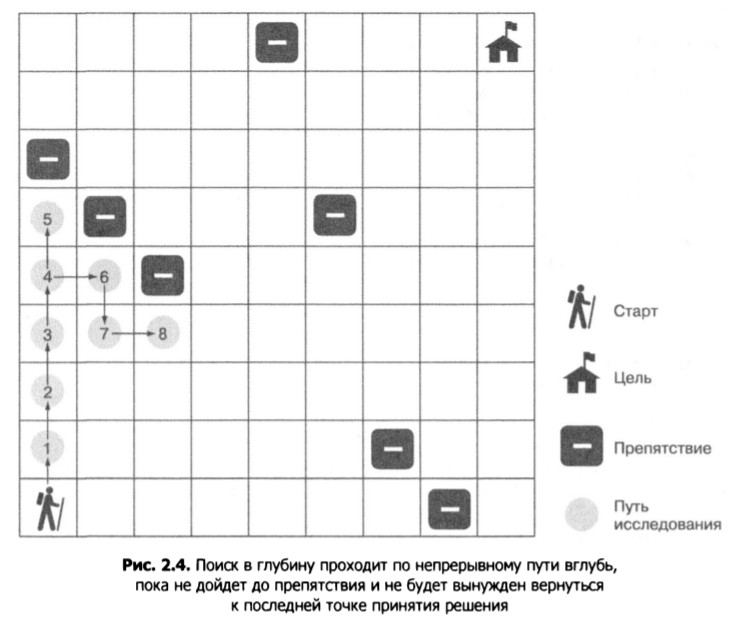
Для реализации поиска в глубину используется стек. **Стек** - это структура данных, которая работает по принципу *LIFO (последним зашел - первым вышел)*.

In [46]:
class Stack:
    def __init__(self):
        self._container = []
    def push(self, elem):
        self._container.append(elem)
    def pop(self):
        self._container.pop()
    def empty(self):
        return self._container == []
    def __repr__(self):
        return repr(self._container)

## Миссионеры и людоеды
Три миссионера и три людоеда находятся на западном берегу реки. У них есть каноэ, в котором помещаются двое. И миссионеры, и людоеды должны переехать на восточный берег реки. Нельзя, чтобы на одной стороне реки в какой-то момент оказалось больше людоедов, чем миссионеров. В Каноэ всега должен находиться хотя бы один человек, чтобы пересечь реку.

**Задача:** определить последовательность переправ, которая позволит перевести всех через реку
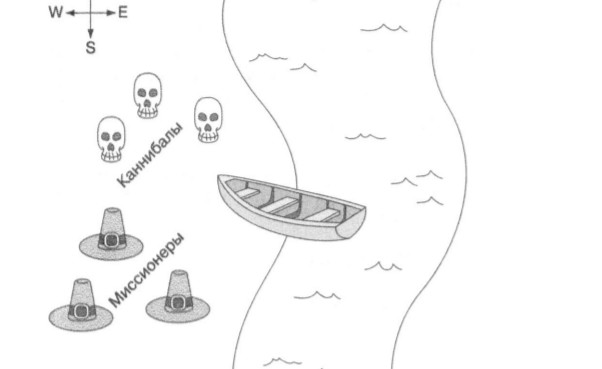